In [3]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np
from tqdm import tqdm

In [5]:
# Discards the smallest alpha% samples at every iteration
def bwgd_smooth(y, A, e, alpha=0, eta=1, niter=40):
    d, n = A.shape  
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)
    threshold = int(alpha * n)

    # Descent
    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]

        # Descent
        sum_gradient = A_tilde @ (np.sqrt(y_filtered+e**2) * (A_tilde.T @ x_tilde) / np.sqrt((A_tilde.T @ x_tilde)**2 + e**2))
        x_tilde = (1 - eta) * x_tilde + (eta / n) * sum_gradient

        x[iter] = C_inv @ x_tilde
        
    return x

# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < 1e-11
    return zero_error

# Take minimum error for positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-1*x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

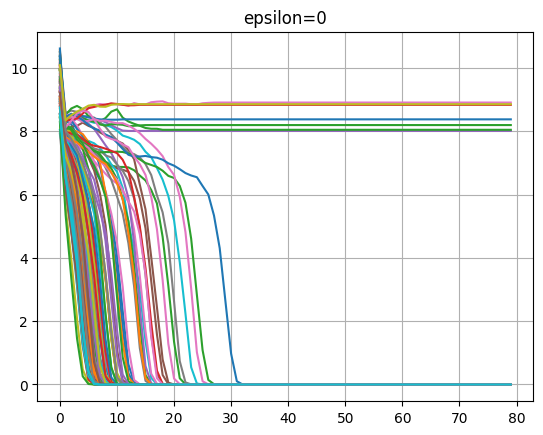

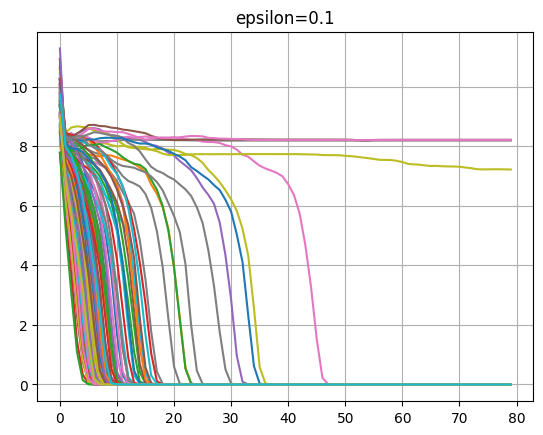

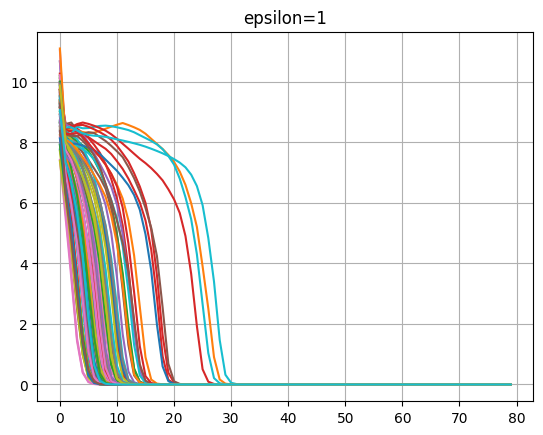

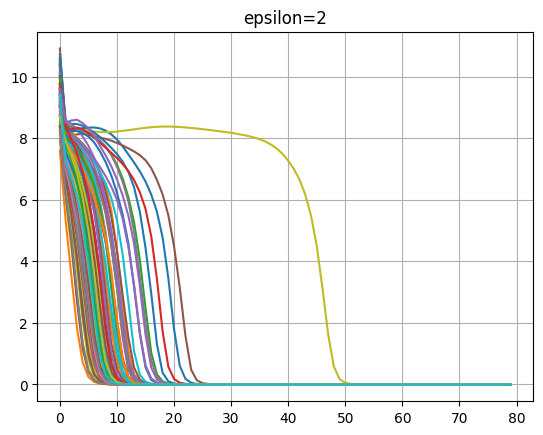

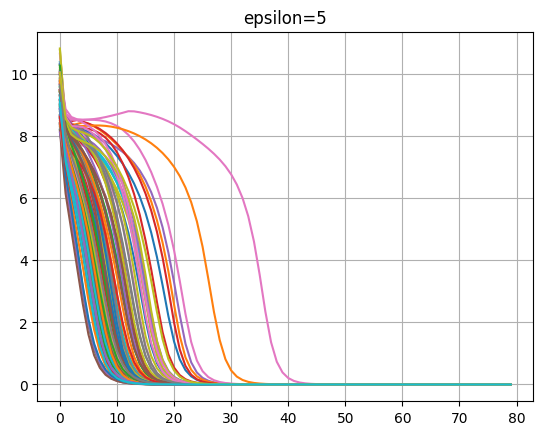

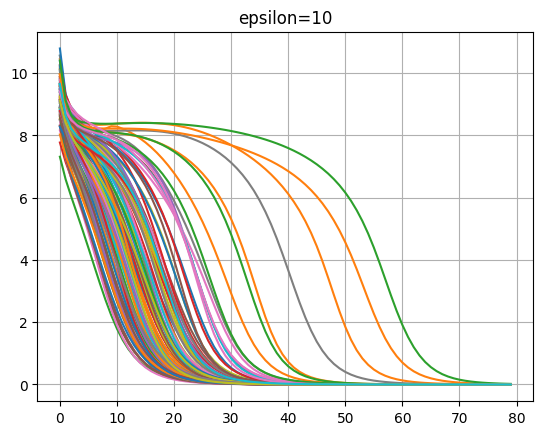

{0: 93, 0.1: 96, 1: 100, 2: 100, 5: 93, 10: 0}

In [6]:
n = 1000
d = 50
errors = []
epsilons =  [0, 0.1, 1, 2, 5, 10]

for e in epsilons:
    e_error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_smooth(y, A, e, niter=80)

        error = min_error(x_hat, x)
        e_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(e_error)

    plt.title(f'epsilon={e}')
    plt.grid(True)
    plt.show()

convergence_counts(errors, epsilons)

In [12]:
samples = np.arange(100, 1100, 100)  
epsilons = [0,1,2,3,4,5,6]
convergence = np.zeros((len(samples), len(epsilons)))
x_true = np.ones(d)
    
for i, n in tqdm(enumerate(samples)):
    for j, e in enumerate(epsilons):
        converged = 0
        for _ in range(100):
            # Generate random samples A and response y
            A = np.random.randn(d, n)
            y = (A.T @ x_true)**2  
                
            # Run algorithm
            x_hat = bwgd_smooth(y, A, e, niter=80)

            # Check for convergence
            if min_error(x_hat, x_true)[-1] < 1e-11:
                converged += 1 

        convergence[i, j] = converged
        

10it [32:37, 195.72s/it]


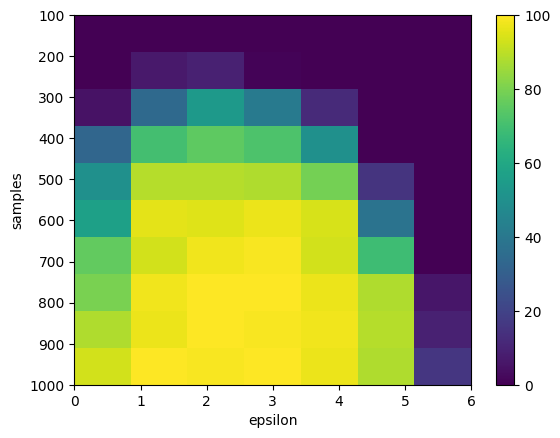

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   7.,   9.,   1.,   0.,   0.,   0.],
       [  5.,  34.,  54.,  41.,  12.,   0.,   0.],
       [ 33.,  70.,  75.,  72.,  50.,   0.,   0.],
       [ 50.,  89.,  89.,  88.,  79.,  15.,   0.],
       [ 57.,  96.,  95.,  97.,  94.,  38.,   0.],
       [ 76.,  93.,  98.,  99.,  93.,  69.,   0.],
       [ 80.,  98., 100., 100.,  97.,  88.,   6.],
       [ 88.,  97., 100.,  99.,  98.,  89.,   9.],
       [ 93., 100.,  99., 100.,  97.,  88.,  16.]])

In [13]:
plt.imshow(convergence, extent=[epsilons[0],epsilons[-1], samples[-1],samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('epsilon')
plt.ylabel('samples')
plt.title('')
plt.show()
convergence

tolerance too small for higher e to converge? 2 is the sweet spot?

Try discarding samples?

Check a final tolerance level with tyler

Phase transitions

In [18]:
samples = np.arange(100, 1100, 100)  
alphas = np.arange(0, 10) * 0.1  
convergence = np.zeros((len(samples), len(alphas)))
x_true = np.ones(d)
    
for i, n in enumerate(samples):
    for j, alpha in enumerate(alphas):
        converged = 0
        for _ in range(100):
            # Generate random samples A and response y
            A = np.random.randn(d, n)
            y = (A.T @ x_true)**2  
                
            # Run algorithm
            x_hat = bwgd_smooth(y, A, e=2, alpha=alpha, niter=80)

            # Check for convergence
            if min_error(x_hat, x_true)[-1] < 1e-11:
                converged += 1 

        convergence[i, j] = converged    

C:\Users\gabreu\AppData\Local\Temp\ipykernel_19440\4108902162.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde


array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 13.,  16.,  23.,  18.,  20.,  40.,  21.,  42.,   0.,   0.],
       [ 54.,  57.,  58.,  60.,  61.,  84.,  80.,  74.,  96.,   0.],
       [ 70.,  80.,  80.,  87.,  81.,  92.,  95.,  98.,  96.,   0.],
       [ 93.,  90.,  91.,  96.,  90.,  97.,  96.,  99.,  98.,   4.],
       [ 96.,  94.,  94.,  96.,  97.,  98.,  98., 100., 100., 100.],
       [ 98.,  98.,  99.,  99.,  99.,  98.,  98., 100., 100., 100.],
       [ 98.,  99.,  99.,  98.,  97.,  99.,  99., 100., 100., 100.],
       [ 99., 100., 100.,  99.,  99., 100.,  99., 100., 100., 100.],
       [ 99., 100., 100.,  99., 100., 100., 100., 100., 100., 100.]])

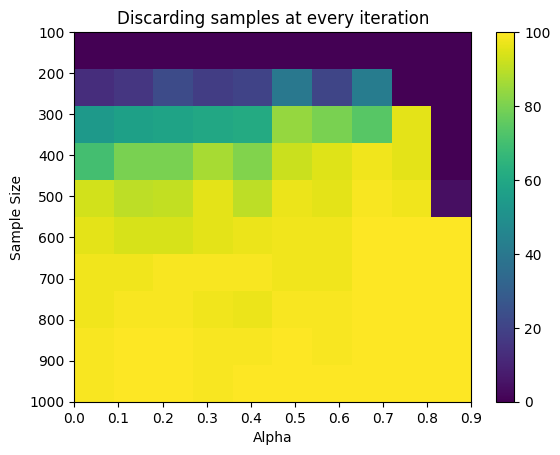

In [19]:
im = plt.imshow(convergence, extent=[alphas[0], alphas[-1], samples[-1], samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Sample Size')
plt.title('Discarding samples at every iteration')
convergence